In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs


Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), 117.80 MiB | 6.59 MiB/s, done.
Updating files: 100% (4/4), done.


In [2]:
!dir german-traffic-signs


signnames.csv  test.p  train.p	valid.p


In [4]:
!pip install keras


In [2]:
!pip install --upgrade keras

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2

In [5]:
np.random.seed(0)

#loading the train.p pickle file
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)

#loading the valid.p pickle file
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

# loading the test.p pickle file
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)


# Splitting out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

print("The dimensions of x_train is:",X_train.shape)
print("The dimensions of x_test is:",X_test.shape)
print("The dimensions of x_val is:",X_val.shape)

The dimensions of x_train is: (34799, 32, 32, 3)
The dimensions of x_test is: (12630, 32, 32, 3)
The dimensions of x_val is: (4410, 32, 32, 3)


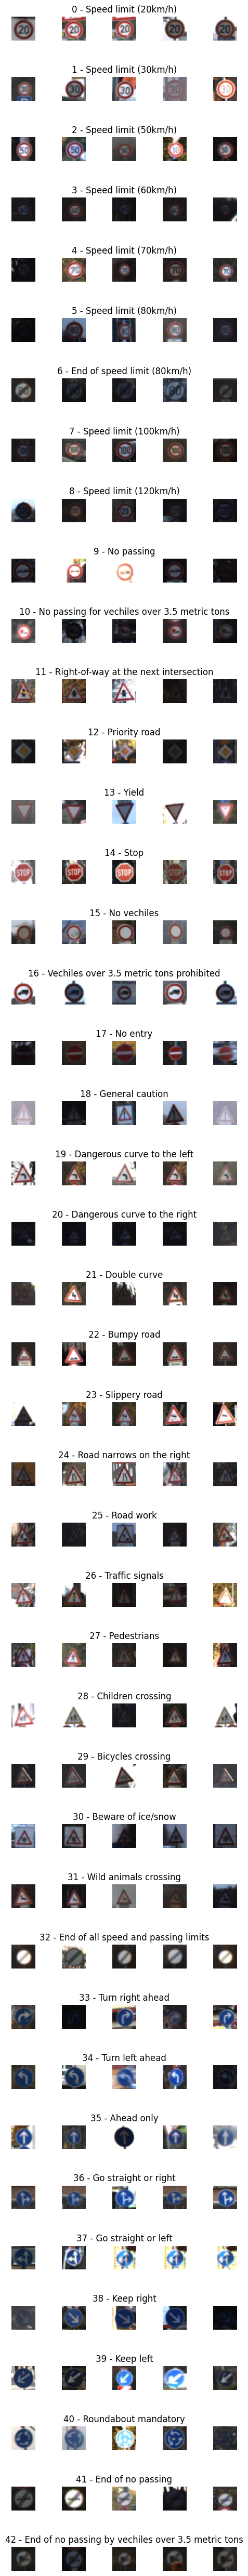

In [6]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
           axs[j][i].set_title(str(j) + " - " + row["SignName"])
           num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


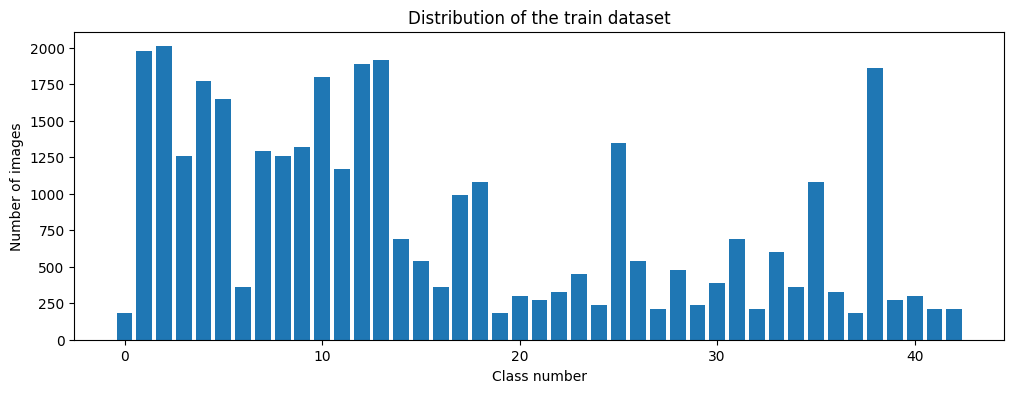

In [7]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


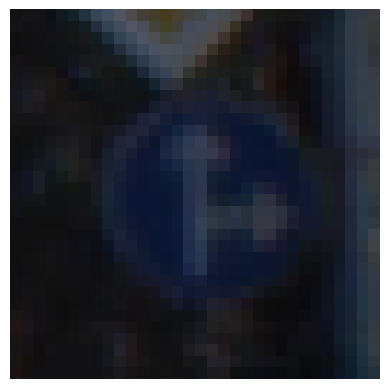

In [8]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

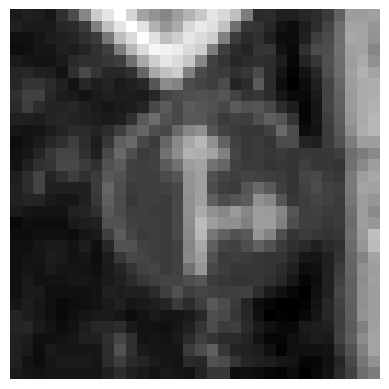

(32, 32)


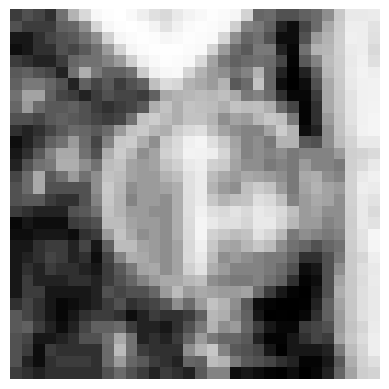

(32, 32)


In [10]:
img = grayscale(X_train[1000])
plt.imshow(img, cmap='gray')  # Specify the colormap for grayscale
plt.axis("off")
plt.show()  # Display the grayscale image

print(img.shape)

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img, cmap='gray')  # Specify the colormap for grayscale
plt.axis("off")
plt.show()  # Display the equalized image

print(img.shape)

def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img


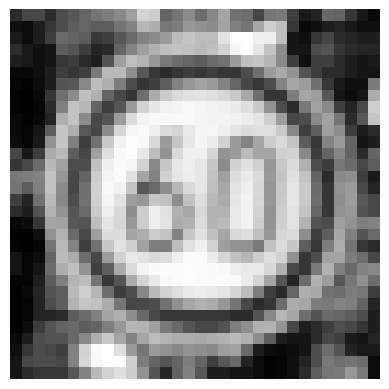

(32, 32)


In [11]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

plt.imshow(X_train[random.randint(0, len(X_train) - 1)], cmap='gray')  # Display a random preprocessed image
plt.axis('off')
plt.show()

print(X_train[0].shape)  # Print the shape of the first preprocessed image


In [12]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

the X_batch shape is: (15, 32, 32, 1)


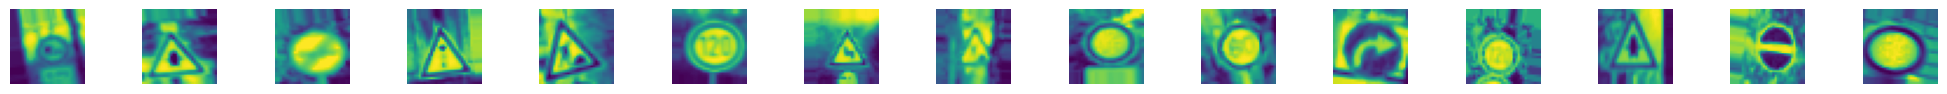

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

datagen.fit(X_train)


batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print("the X_batch shape is:",X_batch.shape)

In [22]:
def modified_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))

    # Use 'learning_rate' instead of 'lr'
    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = modified_model()
print(model.summary())

history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                    steps_per_epoch=X_train.shape[0] // 50,
                    epochs=15,
                    validation_data=(X_val, y_val),
                    shuffle=1)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                 │ (None, 28, 28, 60)            │       1,560 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_37 (Conv2D)                 │ (None, 24, 24, 60)            │      90,060 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_38 (Conv2D)                 │ (None, 20, 20, 60)            │      90,060 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_12 (MaxPooling2D)    │ (None, 10, 10, 60)            │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_39 (Conv2D)                 │ (None, 8, 8, 30)              │      16,230 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_40 (Conv2D)                 │ (None, 6, 6, 30)              │       8,130 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_41 (Conv2D)                 │ (None, 4, 4, 30)              │       8,130 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_13 (MaxPooling2D)    │ (None, 2, 2, 30)              │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_6 (Flatten)                │ (None, 120)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_12 (Dense)                   │ (None, 500)                   │      60,500 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout_6 (Dropout)                │ (None, 500)                   │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_13 (Dense)                   │ (None, 43)                    │      21,543 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 296,213 (1.13 MB)

 Trainable params: 296,213 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
695/695 ━━━━━━━━━━━━━━━━━━━━ 509s 726ms/step - accuracy: 0.2280 - loss: 2.8114 - val_accuracy: 0.8617 - val_loss: 0.3833
Epoch 2/15
695/695 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.7200 - loss: 0.4232 - val_accuracy: 0.8662 - val_loss: 0.3769
Epoch 3/15
695/695 ━━━━━━━━━━━━━━━━━━━━ 528s 707ms/step - accuracy: 0.7860 - loss: 0.6976 - val_accuracy: 0.9567 - val_loss: 0.1400
Epoch 4/15
695/695 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 1.0000 - loss: 0.0433 - val_accuracy: 0.9569 - val_loss: 0.1332
Epoch 5/15
695/695 ━━━━━━━━━━━━━━━━━━━━ 536s 701ms/step - accuracy: 0.8823 - loss: 0.3908 - val_accuracy: 0.9778 - val_loss: 0.0703
Epoch 6/15
695/695 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9400 - loss: 0.1402 - val_accuracy: 0.9757 - val_loss: 0.0727
Epoch 7/15
695/695 ━━━━━━━━━━━━━━━━━━━━ 550s 707ms/step - accuracy: 0.9236 - loss: 0.2527 - val_accuracy: 0.9814 - val_loss: 0.0653
Epoch 8/15
695/695 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.9400 - lo

Text(0.5, 0, 'epoch')

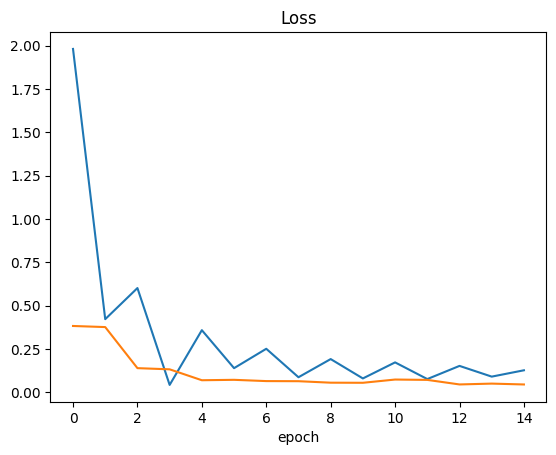

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

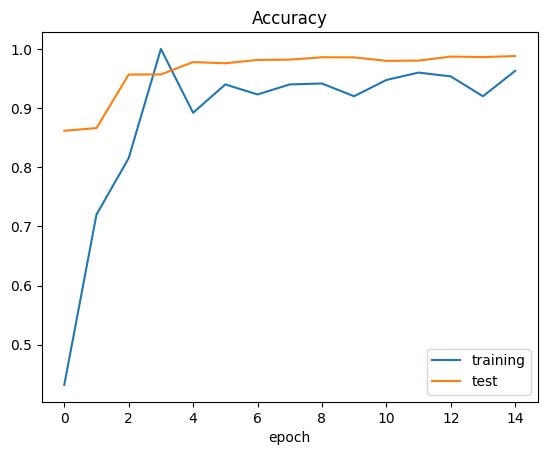

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')


In [25]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.12858587503433228
Test accuracy: 0.9700712561607361


(32, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted class: 23
the detected sign is Slippery road


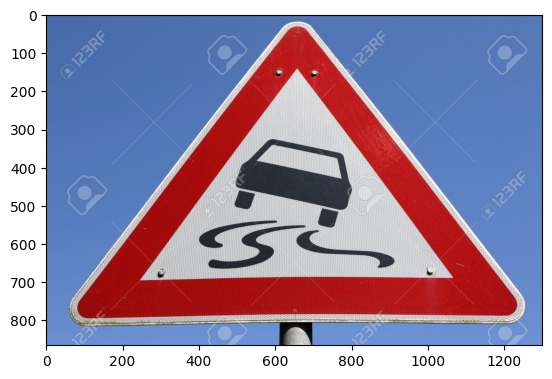

In [36]:
import requests
from PIL import Image

#slippery road sign url link
url = 'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg'

#speeed limit 30kmph sign url link
#url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'

#Yield sign url link
#url='https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg'


r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
#plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

predicted_class = np.argmax(model.predict(img), axis=-1)
classNo = int(predicted_class)
print("Predicted class:", classNo)


def getCalssName(classNo):
  if   classNo == 0: return 'Speed Limit 20 km/h'
  elif classNo == 1: return 'Speed Limit 30 km/h'
  elif classNo == 2: return 'Speed Limit 50 km/h'
  elif classNo == 3: return 'Speed Limit 60 km/h'
  elif classNo == 4: return 'Speed Limit 70 km/h'
  elif classNo == 5: return 'Speed Limit 80 km/h'
  elif classNo == 6: return 'End of Speed Limit 80 km/h'
  elif classNo == 7: return 'Speed Limit 100 km/h'
  elif classNo == 8: return 'Speed Limit 120 km/h'
  elif classNo == 9: return 'No passing'
  elif classNo == 10: return 'No passing for vechiles over 3.5 metric tons'
  elif classNo == 11: return 'Right-of-way at the next intersection'
  elif classNo == 12: return 'Priority road'
  elif classNo == 13: return 'Yield'
  elif classNo == 14: return 'Stop'
  elif classNo == 15: return 'No vechiles'
  elif classNo == 16: return 'Vechiles over 3.5 metric tons prohibited'
  elif classNo == 17: return 'No entry'
  elif classNo == 18: return 'General caution'
  elif classNo == 19: return 'Dangerous curve to the left'
  elif classNo == 20: return 'Dangerous curve to the right'
  elif classNo == 21: return 'Double curve'
  elif classNo == 22: return 'Bumpy road'
  elif classNo == 23: return 'Slippery road'
  elif classNo == 24: return 'Road narrows on the right'
  elif classNo == 25: return 'Road work'
  elif classNo == 26: return 'Traffic signals'
  elif classNo == 27: return 'Pedestrians'
  elif classNo == 28: return 'Children crossing'
  elif classNo == 29: return 'Bicycles crossing'
  elif classNo == 30: return 'Beware of ice/snow'
  elif classNo == 31: return 'Wild animals crossing'
  elif classNo == 32: return 'End of all speed and passing limits'
  elif classNo == 33: return 'Turn right ahead'
  elif classNo == 34: return 'Turn left ahead'
  elif classNo == 35: return 'Ahead only'
  elif classNo == 36: return 'Go straight or right'
  elif classNo == 37: return 'Go straight or left'
  elif classNo == 38: return 'Keep right'
  elif classNo == 39: return 'Keep left'
  elif classNo == 40: return 'Roundabout mandatory'
  elif classNo == 41: return 'End of no passing'
  elif classNo == 42: return 'End of no passing by vechiles over 3.5 metric tons'

sign=getCalssName(classNo)
print("the detected sign is {}".format(sign))